<a href="https://colab.research.google.com/github/Senume/Automata-Simulator/blob/main/src/Basic_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **MODULE INSTALLATION AND IMPORT**

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from gensim.models import KeyedVectors                    # Loading embedding models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# **IEMOCAP DATASET**

## **LOADING TEXT DATA**

In [ ]:
# Loading the text 
Text_Dataset = pd.read_csv('/content/drive/MyDrive/Multi-Modal Sentiment Analysis/Features/Text_IEMOCAP.csv')

# Dropping a label columen
Text_Dataset = Text_Dataset.drop(['Label'], axis = 1)

## **LOADING AUDIO FEATURES**


In [ ]:
Audio_Features = pd.read_csv('/content/drive/MyDrive/Multi-Modal Sentiment Analysis/Features/AudioFeatures_eGeMAPSv02_IEMOCAP.csv')

## **MERGING BOTH DATASET INTO ONE DATAFRAME**

In [ ]:
# Merging the Data on the columns name 'ID'
Dataset = pd.merge(Text_Dataset, Audio_Features, on = 'ID')

## **DATA ANALYSIS**

<BarContainer object of 10 artists>

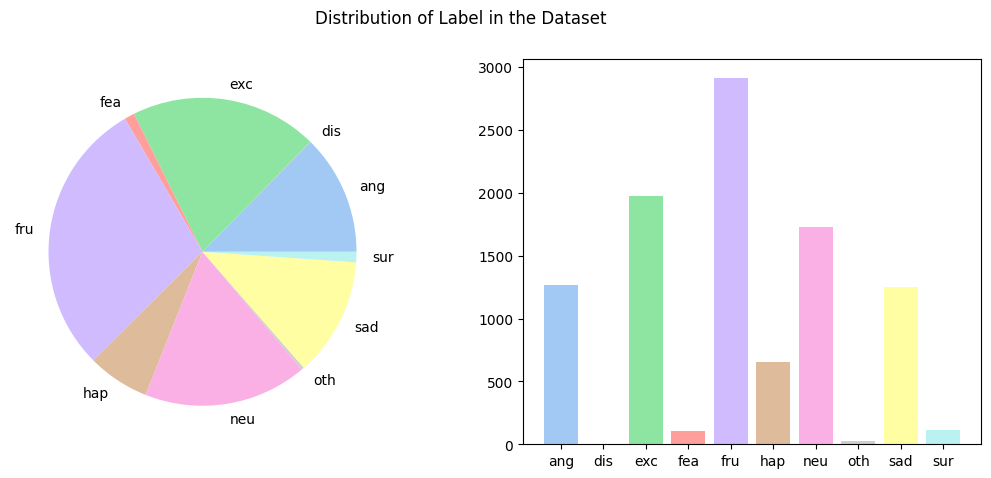

In [ ]:
# Dataset Visualisations
Count = Dataset.groupby('Label')['ID'].count()

# Label count and Labels
Label = Count.keys()
Count = Count.values

# Plotting Pie Chart and Bar graph
colors = sns.color_palette('pastel')[0:len(Label)]

fig,ax = plt.subplots(1,2, figsize = (13,5))
fig.suptitle('Distribution of Label in the Dataset')

ax[0].pie(Count, labels = Label, colors = colors)
ax[1].bar(Label, Count, color = colors)


## **DATA CLEANING AND REDUCTION**

<BarContainer object of 6 artists>

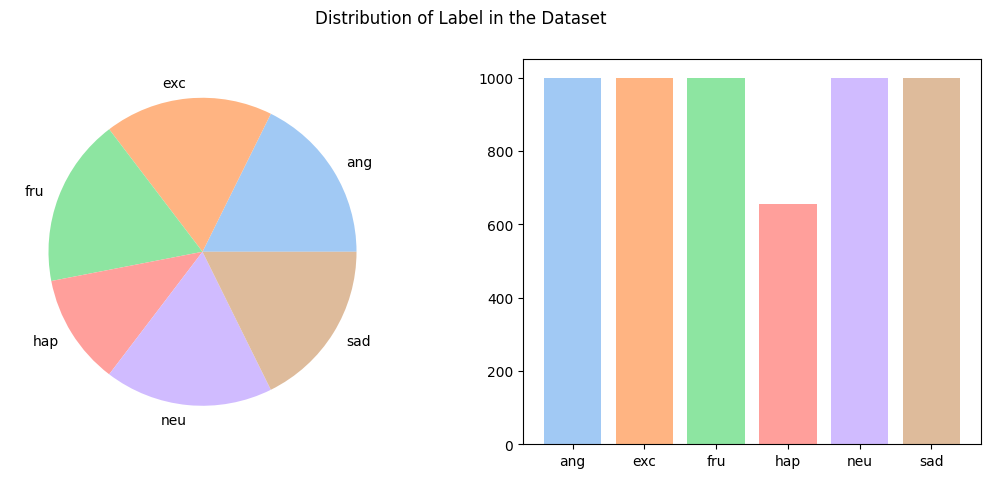

In [ ]:
# Counting Labels and its size
Count = Dataset.groupby('Label')['ID'].count()
Count = pd.DataFrame(Count)

# Labels which satisfies the threshold
Accepted_Labels = Count[Count['ID'] > 500]
Accepted_Labels = list(Accepted_Labels.index)

# Filtering out only required Labels
Dataset = Dataset[Dataset['Label'].isin(Accepted_Labels)]

# Reducing the each category size count to 1000 samples
Dataset = Dataset.groupby('Label').head(1000).reset_index(drop=True)

# Dataset Visualisations
Count = Dataset.groupby('Label')['ID'].count()

# Label count and Labels
Label = Count.keys()
Count = Count.values

# Plotting Pie Chart and Bar graph
colors = sns.color_palette('pastel')[0:len(Label)]

fig,ax = plt.subplots(1,2, figsize = (13,5))
fig.suptitle('Distribution of Label in the Dataset')

ax[0].pie(Count, labels = Label, colors = colors)
ax[1].bar(Label, Count, color = colors)

## **SPLITING THE DATASET**

In [ ]:
# Finding the Unique class present
Label_Unique_Class = pd.unique(Dataset['Label'])

# Labels replacing it with index
Y = pd.CategoricalIndex(Dataset['Label'], categories= Label_Unique_Class).codes

# Features Dataset
X = Dataset.drop(['ID', 'Label'], axis = 1)

# Train, Test, Validation Split
X_Train, X_Val, Y_Train, Y_Val  = train_test_split(X, Y, test_size= 0.3, random_state= 3122, stratify= Y)
X_Train, X_Test, Y_Train, Y_Test  = train_test_split(X_Train, Y_Train, test_size= 0.3, random_state= 542, stratify= Y_Train)

## **LOADING THE PRETRAINED EMBEDDING MODEL AS LAYER**
## **TEMPORARILY NOT IN USE**

In [ ]:
# Loading the pretrained embedding model
model_path = '/content/drive/MyDrive/Multi-Modal Sentiment Analysis/Model/GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(model_path, binary=True)

# Extracting the embedding matrix
embedding_matrix = model.vectors
Input_length = embedding_matrix.shape[0]
Output_length = embedding_matrix.shape[1]

# Creaitng an custom embedding layer
embedding_layer = tf.keras.layers.Embedding(
    input_dim=Input_length,
    output_dim=Output_length,
    weights=[embedding_matrix],
    trainable=False
)

del model, embedding_matrix

## **CREATING AN BASIC LSTM BASED MODEL (ONLY USING TEXT DATA)**

In [ ]:
# Importing needed modules
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Preprocessing
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(Dataset['Text'])

# Extracting sequnces for X_Train, X_Test and X_Val
sequences_Train = tokenizer.texts_to_sequences(X_Train['Text'])
sequences_Test = tokenizer.texts_to_sequences(X_Test['Text'])
sequences_Val = tokenizer.texts_to_sequences(X_Val['Text'])

# Padding the to embedding input length
Input_length = max(max(len(seq) for seq in sequences_Train),max(len(seq) for seq in sequences_Test), max(len(seq) for seq in sequences_Val))


padded_sequences_Train = pad_sequences(sequences_Train, maxlen=Input_length)
padded_sequences_Test = pad_sequences(sequences_Test, maxlen=Input_length)
padded_sequences_Val = pad_sequences(sequences_Val, maxlen=Input_length)

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=Input_length))
model_lstm.add(LSTM(units=64))
model_lstm.add(Dense(units=len(Label_Unique_Class), activation='sigmoid'))

# Compile the model
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_lstm.fit(padded_sequences_Train, Y_Train, validation_data= (padded_sequences_Test, Y_Test),epochs=25, batch_size=32)

Epoch 1/25
87/87 [==============================] - 16s 156ms/step - loss: 1.7715 - accuracy: 0.2288 - val_loss: 1.7366 - val_accuracy: 0.2466
Epoch 2/25
87/87 [==============================] - 11s 128ms/step - loss: 1.5662 - accuracy: 0.3959 - val_loss: 1.5553 - val_accuracy: 0.3636
Epoch 3/25
87/87 [==============================] - 9s 102ms/step - loss: 1.2676 - accuracy: 0.5034 - val_loss: 1.4954 - val_accuracy: 0.4066
Epoch 4/25
87/87 [==============================] - 8s 91ms/step - loss: 1.0430 - accuracy: 0.5991 - val_loss: 1.5347 - val_accuracy: 0.4057
Epoch 5/25
87/87 [==============================] - 10s 111ms/step - loss: 0.8888 - accuracy: 0.6637 - val_loss: 1.6303 - val_accuracy: 0.3948
Epoch 6/25
87/87 [==============================] - 7s 85ms/step - loss: 0.7758 - accuracy: 0.7106 - val_loss: 1.7459 - val_accuracy: 0.3939
Epoch 7/25
87/87 [==============================] - 9s 108ms/step - loss: 0.6921 - accuracy: 0.7423 - val_loss: 1.8192 - val_accuracy: 0.3838
Epoch

54/54 [==============================] - 2s 31ms/step
Accuracy: 0.3965822038892163
Weighted Precision: 0.3897035191106698
Weighted Recall: 0.3965822038892163
Weighted F1 Score: 0.38980033976081085 



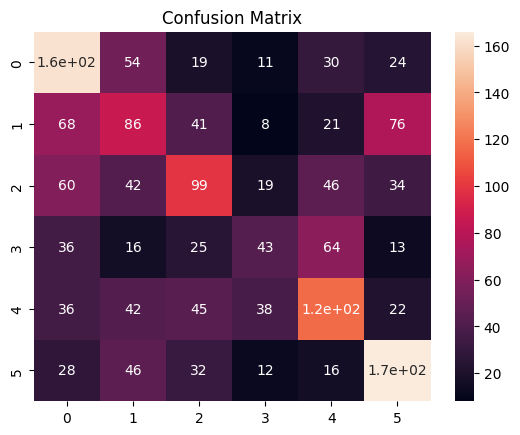

In [ ]:
Y_pred = np.argmax(model_lstm.predict(padded_sequences_Val), axis =1 )

accuracy = accuracy_score(Y_Val, Y_pred)
precision = precision_score(Y_Val, Y_pred, average = 'weighted')
recall = recall_score(Y_Val, Y_pred, average = 'weighted')
f1 = f1_score(Y_Val, Y_pred, average = 'weighted')

print("Accuracy:", accuracy)
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1 Score:", f1, '\n')

A = sns.heatmap(confusion_matrix(Y_Val, Y_pred), annot= True).set_title('Confusion Matrix')


## **CREATING AN BASIC NN MODEL (ONLY USING AUDIO FEATURES)**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Extracting only Audio features
Audio_Train = X_Train.drop('Text', axis = 1)
Audio_Test = X_Test.drop('Text', axis = 1)
Audio_Val = X_Val.drop('Text', axis = 1)

# Input Vector size
Input_size = Audio_Train.shape[1]

# Define the model architecture
model_nn = Sequential()
model_nn.add(Dense(32, activation='relu', input_dim=Input_size)) 
model_nn.add(Dense(len(Label_Unique_Class), activation='sigmoid'))

# Compile the model
model_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_nn.fit(Audio_Train, Y_Train, validation_data= (Audio_Test, Y_Test),epochs=25, batch_size=32)

Epoch 1/25
87/87 [==============================] - 2s 5ms/step - loss: 166.5923 - accuracy: 0.1689 - val_loss: 31.9911 - val_accuracy: 0.1625
Epoch 2/25
87/87 [==============================] - 0s 3ms/step - loss: 22.6496 - accuracy: 0.2003 - val_loss: 23.3143 - val_accuracy: 0.2138
Epoch 3/25
87/87 [==============================] - 0s 3ms/step - loss: 17.1648 - accuracy: 0.2176 - val_loss: 18.1407 - val_accuracy: 0.2449
Epoch 4/25
87/87 [==============================] - 0s 3ms/step - loss: 14.0290 - accuracy: 0.2389 - val_loss: 16.4395 - val_accuracy: 0.2736
Epoch 5/25
87/87 [==============================] - 0s 3ms/step - loss: 12.6108 - accuracy: 0.2483 - val_loss: 14.0754 - val_accuracy: 0.2466
Epoch 6/25
87/87 [==============================] - 0s 3ms/step - loss: 10.3622 - accuracy: 0.2472 - val_loss: 13.3832 - val_accuracy: 0.2702
Epoch 7/25
87/87 [==============================] - 0s 3ms/step - loss: 8.7475 - accuracy: 0.2717 - val_loss: 11.0865 - val_accuracy: 0.2247
Epoch 

54/54 [==============================] - 0s 1ms/step
Accuracy: 0.1773718326458456
Weighted Precision: 0.3829327515808038
Weighted Recall: 0.1773718326458456
Weighted F1 Score: 0.056406887823221494 



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


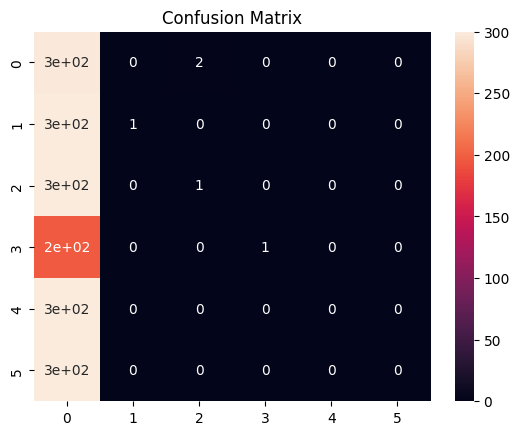

In [ ]:
Y_pred = np.argmax(model_nn.predict(Audio_Val), axis =1 )

accuracy = accuracy_score(Y_Val, Y_pred)
precision = precision_score(Y_Val, Y_pred, average = 'weighted')
recall = recall_score(Y_Val, Y_pred, average = 'weighted')
f1 = f1_score(Y_Val, Y_pred, average = 'weighted')

print("Accuracy:", accuracy)
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1 Score:", f1, '\n')

A = sns.heatmap(confusion_matrix(Y_Val, Y_pred), annot= True).set_title('Confusion Matrix')

## **CREATING AN MULTI-MODAL BASED MODEL PROTOTYPE**

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input
from tensorflow.keras.models import Model

# Input Data Processsing

# Audio Features

Audio_Train = X_Train.drop('Text', axis = 1)
Audio_Test = X_Test.drop('Text', axis = 1)
Audio_Val = X_Val.drop('Text', axis = 1)

# Text Preprocessed

# Defining the Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(Dataset['Text'])

# Converting tokens into sequence
sequences_Train = tokenizer.texts_to_sequences(X_Train['Text'])
sequences_Test = tokenizer.texts_to_sequences(X_Test['Text'])
sequences_Val = tokenizer.texts_to_sequences(X_Val['Text'])

# Padding the to embedding input length
Input_length = max(max(len(seq) for seq in sequences_Train),max(len(seq) for seq in sequences_Test), max(len(seq) for seq in sequences_Val))

# Getting padded Sequence
padded_sequences_Train = pad_sequences(sequences_Train, maxlen=Input_length)
padded_sequences_Test = pad_sequences(sequences_Test, maxlen=Input_length)
padded_sequences_Val = pad_sequences(sequences_Val, maxlen=Input_length)


# Defining NN Design for Audio features

NN_input = Input(shape= (Audio_Train.shape[1]),)
NN_dense_1 = Dense(64, activation= 'relu')(NN_input)
NN_output = Dense(23, activation= 'relu')(NN_dense_1)


# Defining LSTM for Text Sequence

LSTM_input = Input(shape=(Input_length,))
LSTM_embedding = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100)(LSTM_input)
Seq_Output, LSTM_hidden, LSTM_c = LSTM(units=64, return_sequences=True, return_state = True)(LSTM_embedding)

# Concatenating each result with dense network

COMB_output = tf.keras.layers.concatenate([NN_output, LSTM_hidden, LSTM_c])
Dense_output = Dense(64, activation= 'relu')(COMB_output)
Output = Dense(len(Label_Unique_Class), activation= 'sigmoid')(Dense_output)

# Defining a model
func_model = Model(inputs=[NN_input, LSTM_input], outputs=Output)

In [ ]:
# COmpiling the functional model
func_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics =['accuracy'])

# Training the model with given input
func_model.fit([Audio_Train, padded_sequences_Train], Y_Train, epochs=25, batch_size=32, validation_data=([Audio_Test, padded_sequences_Test], Y_Test))


Epoch 1/25
87/87 [==============================] - 13s 108ms/step - loss: 29.9461 - accuracy: 0.1877 - val_loss: 2.7099 - val_accuracy: 0.2155
Epoch 2/25
87/87 [==============================] - 8s 89ms/step - loss: 2.2873 - accuracy: 0.2364 - val_loss: 2.0875 - val_accuracy: 0.2534
Epoch 3/25
87/87 [==============================] - 9s 102ms/step - loss: 1.6457 - accuracy: 0.3948 - val_loss: 1.8207 - val_accuracy: 0.3493
Epoch 4/25
87/87 [==============================] - 7s 79ms/step - loss: 1.2776 - accuracy: 0.5222 - val_loss: 1.9812 - val_accuracy: 0.3754
Epoch 5/25
87/87 [==============================] - 9s 108ms/step - loss: 1.0403 - accuracy: 0.6041 - val_loss: 1.8400 - val_accuracy: 0.3830
Epoch 6/25
87/87 [==============================] - 8s 90ms/step - loss: 0.8584 - accuracy: 0.6777 - val_loss: 1.9703 - val_accuracy: 0.3914
Epoch 7/25
87/87 [==============================] - 8s 92ms/step - loss: 0.7734 - accuracy: 0.7048 - val_loss: 2.0470 - val_accuracy: 0.3779
Epoch 8/

54/54 [==============================] - 2s 30ms/step
Accuracy: 0.41013553329404834
Weighted Precision: 0.4239828769455081
Weighted Recall: 0.41013553329404834
Weighted F1 Score: 0.41460934038666436 



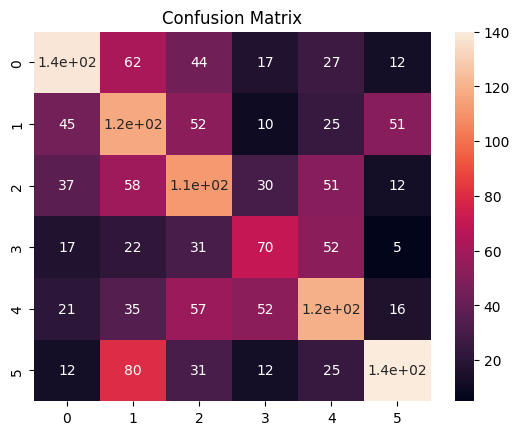

In [ ]:
Y_pred = np.argmax(func_model.predict([Audio_Val, padded_sequences_Val]), axis =1 )

accuracy = accuracy_score(Y_Val, Y_pred)
precision = precision_score(Y_Val, Y_pred, average = 'weighted')
recall = recall_score(Y_Val, Y_pred, average = 'weighted')
f1 = f1_score(Y_Val, Y_pred, average = 'weighted')

print("Accuracy:", accuracy)
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1 Score:", f1, '\n')

A = sns.heatmap(confusion_matrix(Y_Val, Y_pred), annot= True).set_title('Confusion Matrix')